<a href="https://colab.research.google.com/github/harithayallupu2005/Fmml-lab-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 15:05:17--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.138.94.103, 108.138.94.32, 108.138.94.65, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.138.94.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  84.4MB/s    in 0.5s    

2024-05-12 15:05:18 (84.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


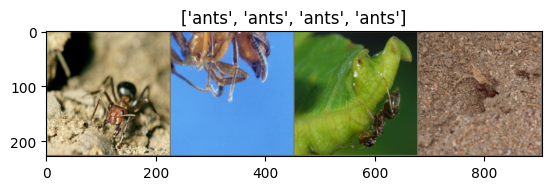

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.7MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6444 Acc: 0.6967

Epoch 1/4
----------
Loss: 0.5534 Acc: 0.8115

Epoch 2/4
----------
Loss: 0.5167 Acc: 0.7951

Epoch 3/4
----------
Loss: 0.7240 Acc: 0.7500

Epoch 4/4
----------
Loss: 0.4313 Acc: 0.8074



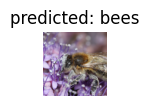

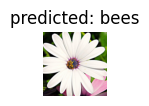

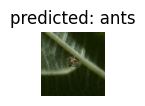

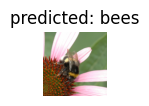

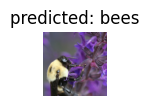

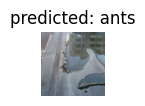

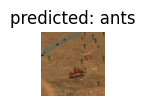

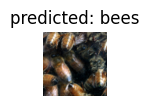

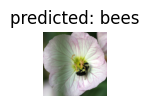

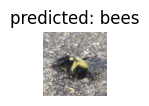

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


# **QUESTION-1:**

### **Q:What is the significance of using data augmentations like resize, crop etc on training data?**

### **ANS:**

Data augmentation techniques such as resizing, cropping, flipping, rotation, and adding noise serve several important purposes in training machine learning models, particularly in computer vision tasks. Here's why they're significant:

**1.Increased Robustness:** By applying various transformations to the training data, the model learns to recognize objects or patterns under different conditions. This increases the robustness of the model and its ability to generalize well to unseen data.

**2.Expanded Dataset:** Data augmentation effectively expands the size of the training dataset without collecting additional labeled data. This is particularly beneficial when the original dataset is small, helping to prevent overfitting and improve model performance.

**3.Translation Invariance:** Techniques like cropping and resizing help the model become invariant to translations. This means the model can recognize objects regardless of their position or scale within the image.

**4.Rotation Invariance:** Rotating images randomly during training helps the model become invariant to rotation, enabling it to recognize objects at various orientations.

**5.Improving Diversity:** Data augmentation introduces diversity into the training data by generating new samples with different characteristics. This helps prevent the model from memorizing specific features of the training images and encourages it to learn more robust and generalizable features.

**6.Regularization:** Data augmentation acts as a form of regularization, helping to prevent overfitting by adding noise to the training process. This encourages the model to learn more generalizable representations of the data.

**7.Adaptation to Real-world Scenarios:** Applying transformations that mimic real-world scenarios (such as changes in lighting conditions, occlusions, or distortions) helps the model become more robust when deployed in real-world environments where such variations are common.

**8.Label-preserving Augmentations:** Many data augmentation techniques, such as flipping or rotating an image, preserve the label associated with the image. This ensures that the augmented data remains semantically similar to the original data, which is crucial for effective training.

Overall, data augmentation is a powerful technique for improving the performance and robustness of machine learning models, particularly in scenarios where labeled training data is limited or when the model needs to perform well under diverse conditions.








### **QUESTION:2**

### **Q:What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)**

### **ANS:**

If you train a ResNet model from scratch without using pretraining, you may encounter several challenges:

**1.Increased Training Time:** Training a deep neural network like ResNet from scratch requires a large amount of data and computational resources. Without pretraining, the model starts from random initialization, which often leads to longer training times compared to using pretrained weights.

**2.Need for Large Datasets:** Training a deep neural network from scratch typically requires a large dataset to avoid overfitting. Without the benefit of pretrained weights, the model needs to learn meaningful representations of the data entirely from scratch, which can be challenging with limited data.

**3.Risk of Overfitting:** Without the regularization effect of pretrained weights, there's a higher risk of overfitting, especially when training on smaller datasets. The model may memorize the training examples instead of learning generalizable features.

**4.Lower Performance:** In many cases, training a deep neural network from scratch may result in lower performance compared to using pretrained weights. Pretrained models have already learned useful feature representations from large datasets, which can significantly boost performance, especially when fine-tuned on a specific task.

However, the exact performance you would achieve by training a ResNet model from scratch depends on various factors such as the size and quality of your dataset, the complexity of the task, the model architecture, hyperparameters, and training procedures. It's generally recommended to use transfer learning with pretrained models whenever possible, as it often leads to faster convergence, better generalization, and higher performance, especially when dealing with limited data.







### **QUESTION:3**

### **Q:If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?**

**ANS:**

The performance of a pretrained ResNet model on a different dataset (significantly different from the original training data) can vary depending on several factors:

**1.Domain Similarity:** If the dataset on which the ResNet model was pretrained is from a domain that shares similarities with the ants vs bees dataset (e.g., both datasets contain images of insects), then the pretrained model may still capture useful features that generalize well to the new dataset.

**2.Level of Abstraction:** The lower layers of deep neural networks tend to learn low-level features like edges, textures, and colors, which are often transferable across domains. As we move higher up the network, the learned features become more domain-specific. If the lower layers capture general features that are relevant to the new dataset, the pretrained model may still provide benefits.

**3.Fine-tuning:** Even if the pretrained model's features are not directly applicable to the new dataset, fine-tuning the model on the new dataset can help adapt it to the target task. By updating the weights of the pretrained model during fine-tuning, the model can learn to extract features that are more relevant to the new dataset.

**4.Amount of Transferable Knowledge:** The effectiveness of transfer learning depends on the amount of transferable knowledge between the source and target domains. If the two domains are vastly different (e.g., medical images vs. natural images), the pretrained features may not transfer well, and performance could be limited.

**5.Data Augmentation and Regularization:** Techniques like data augmentation and regularization can help improve the generalization of pretrained models to new datasets by making the model more robust to variations in the data.

In summary, while using a pretrained ResNet model on a significantly different dataset may still provide benefits, the extent of performance improvement will depend on factors such as domain similarity, level of abstraction of learned features, fine-tuning strategy, and the amount of transferable knowledge between the source and target domains. Experimentation and validation on the specific task and dataset are necessary to determine the effectiveness of using pretrained models.





